<a href="https://colab.research.google.com/github/thanuja-007/webmining-/blob/main/SPOTIFY_ADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#DOWNLOAD REQUIRED PACKAGES
!pip install apache-airflow confluent-kafka pyspark pandas scikit-learn psycopg2-binary python-dotenv flask librosa minio elasticsearch

In [1]:

# Real-time Streaming with Kafka and Spark
# Simulated Kafka Producer
import json
import random
import time
from collections import deque
from IPython.display import clear_output

# Simulated Kafka topic
kafka_topic = deque(maxlen=1000)

def generate_mock_event():
    events = ['play', 'skip', 'like', 'add_to_playlist']
    artists = ['Artist1', 'Artist2', 'Artist3', 'Artist4', 'Artist5']
    songs = [f'Song{i}' for i in range(1, 21)]
    users = [f'user_{i}' for i in range(1, 101)]

    return {
        'user_id': random.choice(users),
        'song_id': random.choice(songs),
        'artist': random.choice(artists),
        'event_type': random.choice(events),
        'timestamp': int(time.time()),
        'duration': random.randint(10, 300)
    }

def run_producer(duration=30):
    start_time = time.time()
    while time.time() - start_time < duration:
        event = generate_mock_event()
        kafka_topic.append(json.dumps(event))
        time.sleep(random.uniform(0.1, 0.5))

    print(f"Produced {len(kafka_topic)} events")

# Run the producer for 30 seconds
run_producer()

Produced 100 events


In [2]:
# Spark Streaming Simulation
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd

# Initialize Spark
spark = SparkSession.builder \
    .appName("SpotifyStreaming") \
    .master("local[*]") \
    .getOrCreate()

# Convert our simulated Kafka topic to a DataFrame
events_list = [json.loads(event) for event in kafka_topic]
pdf = pd.DataFrame(events_list)
df = spark.createDataFrame(pdf)

# Process the data
processed_df = df.groupBy("song_id", "artist", "event_type").count()

# Show results
print("Streaming processing results:")
processed_df.show()

# Calculate aggregations
windowed_counts = df.groupBy("song_id", "artist") \
    .agg(
        count(when(col("event_type") == "play", True)).alias("play_count"),
        count(when(col("event_type") == "like", True)).alias("like_count"),
        count(when(col("event_type") == "skip", True)).alias("skip_count"),
        avg("duration").alias("avg_duration")
    )

print("\nWindowed aggregations:")
windowed_counts.show()

Streaming processing results:
+-------+-------+---------------+-----+
|song_id| artist|     event_type|count|
+-------+-------+---------------+-----+
|  Song3|Artist2|           like|    1|
| Song11|Artist4|           play|    1|
| Song13|Artist1|add_to_playlist|    2|
| Song11|Artist1|           like|    2|
| Song14|Artist4|           like|    1|
| Song10|Artist4|           skip|    1|
| Song17|Artist3|add_to_playlist|    1|
|  Song7|Artist3|           like|    1|
|  Song6|Artist1|           skip|    1|
|  Song4|Artist3|           play|    1|
|  Song3|Artist4|           skip|    1|
| Song19|Artist5|           like|    1|
|  Song4|Artist3|add_to_playlist|    2|
|  Song4|Artist5|           skip|    1|
| Song12|Artist5|           like|    1|
|  Song8|Artist5|add_to_playlist|    1|
|  Song1|Artist3|add_to_playlist|    2|
| Song15|Artist5|           skip|    1|
|  Song2|Artist4|           skip|    1|
|  Song7|Artist5|           skip|    1|
+-------+-------+---------------+-----+
only showi

In [4]:
import pandas as pd
from sqlalchemy import create_engine, text

# 1. Data Extraction
def extract_data():
    """Generate mock song data"""
    data = {
        'song_id': [f'S{i}' for i in range(1, 11)],
        'title': [f'Song {i}' for i in range(1, 11)],
        'artist': [f'Artist {i}' for i in range(1, 11)],
        'duration': [180, 210, 195, 230, 165, 200, 220, 190, 240, 170],
        'genre': ['Pop', 'Rock', 'HipHop', 'Electronic', 'Jazz',
                  'Pop', 'Rock', 'HipHop', 'Electronic', 'Jazz'],
        'release_year': [2020, 2019, 2021, 2018, 2022, 2020, 2019, 2021, 2018, 2022]
    }
    return pd.DataFrame(data)

# 2. Data Transformation
def transform_data(df):
    """Add derived columns to the dataset"""
    df['duration_min'] = df['duration'] / 60
    df['is_recent'] = df['release_year'] >= 2020
    return df

# 3. Data Loading (Fixed Version)
def load_data(df):
    """Load transformed data into SQL database"""
    engine = create_engine('sqlite:///spotify.db')  # File-based SQLite

    # Create table using raw SQL
    with engine.begin() as conn:  # Automatically commits transactions
        conn.execute(text("DROP TABLE IF EXISTS songs"))
        conn.execute(text("""
            CREATE TABLE songs (
                song_id TEXT PRIMARY KEY,
                title TEXT,
                artist TEXT,
                duration INTEGER,
                genre TEXT,
                release_year INTEGER,
                duration_min REAL,
                is_recent BOOLEAN
            )
        """))

    # Load data using pandas
    df.to_sql('songs', engine, if_exists='append', index=False, method='multi')
    print("✅ Data loaded successfully.")
    return engine

# Run the complete ETL pipeline
if __name__ == "__main__":
    print("📥 1. Extracting data...")
    raw_data = extract_data()
    print(raw_data.head())

    print("\n🔄 2. Transforming data...")
    transformed_data = transform_data(raw_data)
    print(transformed_data.head())

    print("\n🧩 3. Loading data...")
    db_engine = load_data(transformed_data)

    print("\n🔎 4. Verifying loaded data...")
    with db_engine.connect() as conn:
        result = conn.execute(text("SELECT * FROM songs LIMIT 5"))
        print("\nFirst 5 records in database:")
        for row in result:
            print(row)

        count = conn.execute(text("SELECT COUNT(*) FROM songs")).scalar()
        print(f"\n📊 Total records loaded: {count}")


📥 1. Extracting data...
  song_id   title    artist  duration       genre  release_year
0      S1  Song 1  Artist 1       180         Pop          2020
1      S2  Song 2  Artist 2       210        Rock          2019
2      S3  Song 3  Artist 3       195      HipHop          2021
3      S4  Song 4  Artist 4       230  Electronic          2018
4      S5  Song 5  Artist 5       165        Jazz          2022

🔄 2. Transforming data...
  song_id   title    artist  duration       genre  release_year  duration_min  \
0      S1  Song 1  Artist 1       180         Pop          2020      3.000000   
1      S2  Song 2  Artist 2       210        Rock          2019      3.500000   
2      S3  Song 3  Artist 3       195      HipHop          2021      3.250000   
3      S4  Song 4  Artist 4       230  Electronic          2018      3.833333   
4      S5  Song 5  Artist 5       165        Jazz          2022      2.750000   

   is_recent  
0       True  
1      False  
2       True  
3      False  
4  

In [9]:
import pandas as pd
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Extract song metadata
def extract_data():
    data = {
        'song_id': [f'S{i}' for i in range(1, 11)],
        'title': [f'Song {i}' for i in range(1, 11)],
        'artist': [f'Artist {i}' for i in range(1, 11)],
        'duration': [180, 210, 195, 230, 165, 200, 220, 190, 240, 170],
        'genre': ['Pop', 'Rock', 'HipHop', 'Electronic', 'Jazz',
                  'Pop', 'Rock', 'HipHop', 'Electronic', 'Jazz'],
        'release_year': [2020, 2019, 2021, 2018, 2022, 2020, 2019, 2021, 2018, 2022]
    }
    return pd.DataFrame(data)

# Generate mock user interaction data
def generate_user_interactions():
    users = [f'user_{i}' for i in range(1, 101)]
    songs = [f'S{i}' for i in range(1, 11)]

    data = []
    for user in users:
        for song in songs:
            plays = random.randint(0, 10)
            likes = random.randint(0, plays) if plays > 0 else 0
            skips = random.randint(0, plays - likes) if plays - likes > 0 else 0

            if plays > 0:
                data.append({
                    'user_id': user,
                    'song_id': song,
                    'play_count': plays,
                    'like_count': likes,
                    'skip_count': skips
                })
    return pd.DataFrame(data)

# Unified Recommendation System
class ColabRecommender:
    def __init__(self, song_data, interaction_data):
        self.song_data = song_data
        self.interaction_data = interaction_data
        self.prepare_data()
        self.train_model()

    def prepare_data(self):
        # Merge metadata with interaction
        self.merged_data = pd.merge(
            self.interaction_data,
            self.song_data,
            on='song_id',
            how='left'
        )

        # Create user-song interaction matrix
        self.user_song_matrix = self.merged_data.pivot_table(
            index='user_id',
            columns='song_id',
            values='play_count',
            fill_value=0
        )

        # Content-based features
        content_features = self.song_data.copy()
        content_features = pd.get_dummies(content_features, columns=['genre'])
        numeric_cols = ['duration', 'release_year'] + [col for col in content_features.columns if 'genre_' in col]

        self.scaler = MinMaxScaler()
        self.scaled_features = self.scaler.fit_transform(content_features[numeric_cols])
        self.song_data_indexed = content_features.reset_index(drop=True)

    def train_model(self):
        # KNN for content-based filtering
        self.content_model = NearestNeighbors(n_neighbors=5, metric='cosine')
        self.content_model.fit(self.scaled_features)

    def recommend_content_based(self, song_id, n=5):
        if song_id not in self.song_data_indexed['song_id'].values:
            return []

        idx = self.song_data_indexed[self.song_data_indexed['song_id'] == song_id].index[0]
        distances, indices = self.content_model.kneighbors([self.scaled_features[idx]], n_neighbors=n+1)
        similar_indices = indices[0][1:]
        return self.song_data_indexed.iloc[similar_indices]['song_id'].tolist()

    def recommend_collaborative(self, user_id, n=5):
        if user_id not in self.user_song_matrix.index:
            return []

        user_vector = self.user_song_matrix.loc[user_id].values
        similarities = {}

        # Compute similarity with all other users
        for other_user in self.user_song_matrix.index:
            if other_user == user_id:
                continue
            other_vector = self.user_song_matrix.loc[other_user].values
            sim = np.dot(user_vector, other_vector) / (
                np.linalg.norm(user_vector) * np.linalg.norm(other_vector) + 1e-10)
            similarities[other_user] = sim

        # Top similar users
        top_users = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:10]

        # Recommend songs not yet played by user
        song_scores = {}
        for other_user, sim_score in top_users:
            for song_id, play_count in self.user_song_matrix.loc[other_user].items():
                if self.user_song_matrix.loc[user_id][song_id] == 0 and play_count > 0:
                    song_scores[song_id] = song_scores.get(song_id, 0) + sim_score * play_count

        sorted_songs = sorted(song_scores.items(), key=lambda x: x[1], reverse=True)
        return [song for song, _ in sorted_songs[:n]]

# ------------------ RUNNING THE RECOMMENDER ------------------

# Generate data
song_data = extract_data()
interaction_data = generate_user_interactions()

# Initialize the recommender
recommender = ColabRecommender(song_data, interaction_data)

# Get recommendations
content_recommendations = recommender.recommend_content_based('S1')
collab_recommendations = recommender.recommend_collaborative('user_1')

# Display
print("🎵 Content-based recommendations for S1:", content_recommendations)
print("🧑‍🤝‍🧑 Collaborative recommendations for user_1:", collab_recommendations)



🎵 Content-based recommendations for S1: ['S6', 'S10', 'S5', 'S3', 'S8']
🧑‍🤝‍🧑 Collaborative recommendations for user_1: ['S6', 'S5']


In [11]:
import os
import pandas as pd
from io import StringIO  # Correct import for string IO
from datetime import datetime

class ColabDataLake:
    def __init__(self):
        self.storage = {}
        self.bucket_name = "spotify-data-lake"

    def upload_dataframe(self, df, object_name):
        # Create path structure
        path = os.path.join(self.bucket_name, object_name)

        # Store CSV string in memory (simulating object storage)
        self.storage[path] = df.to_csv(index=False)
        print(f"Uploaded {object_name} to data lake")

    def download_dataframe(self, object_name):
        path = os.path.join(self.bucket_name, object_name)
        if path in self.storage:
            # Use io.StringIO to read CSV from string
            return pd.read_csv(StringIO(self.storage[path]))
        else:
            print(f"Object {object_name} not found")
            return None

# --- Example Usage ---

# Create instance
data_lake = ColabDataLake()

# Create sample DataFrame
metrics_data = pd.DataFrame({
    'song_id': ['S1', 'S2', 'S3'],
    'plays': [100, 200, 150],
    'likes': [50, 75, 60],
    'date': [datetime.now().date()] * 3
})

# Upload to simulated data lake
data_lake.upload_dataframe(metrics_data, 'daily_metrics/2023-01-01.csv')

# Download from simulated data lake
downloaded_data = data_lake.download_dataframe('daily_metrics/2023-01-01.csv')

# Print the result
print("\nDownloaded data:")
print(downloaded_data)


Uploaded daily_metrics/2023-01-01.csv to data lake

Downloaded data:
  song_id  plays  likes        date
0      S1    100     50  2025-06-18
1      S2    200     75  2025-06-18
2      S3    150     60  2025-06-18


<ipython-input-12-1166045632>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='play_count', y='song_id', data=top_songs, palette='viridis')


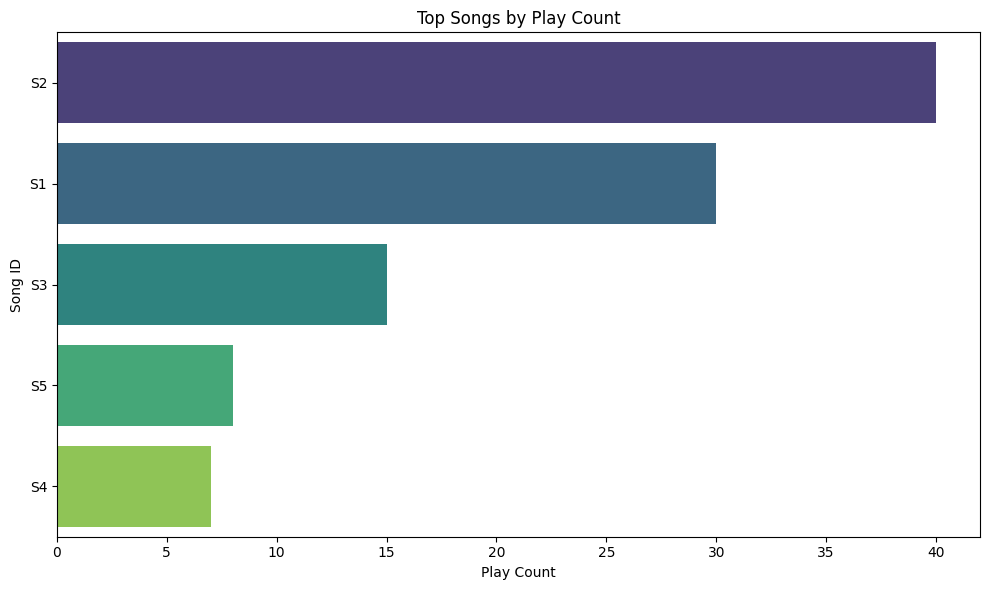

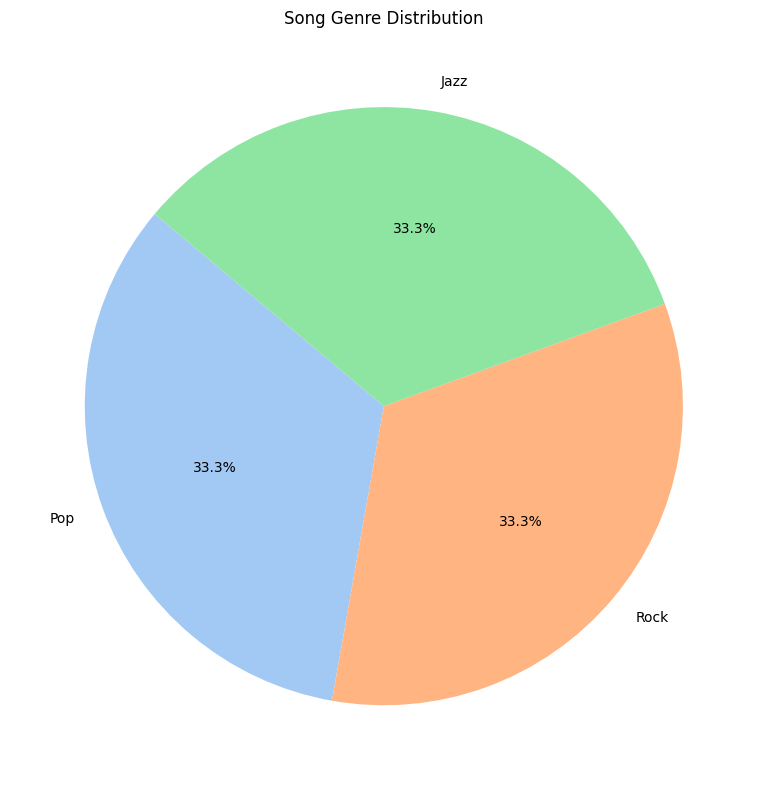

<ipython-input-13-1166045632>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='play_count', y='song_id', data=top_songs, palette='viridis')


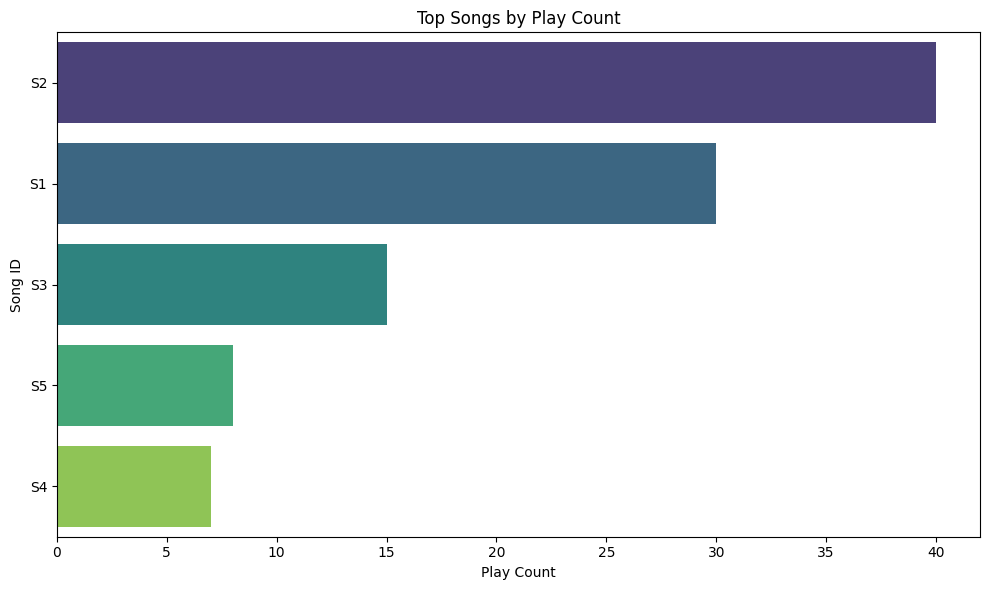

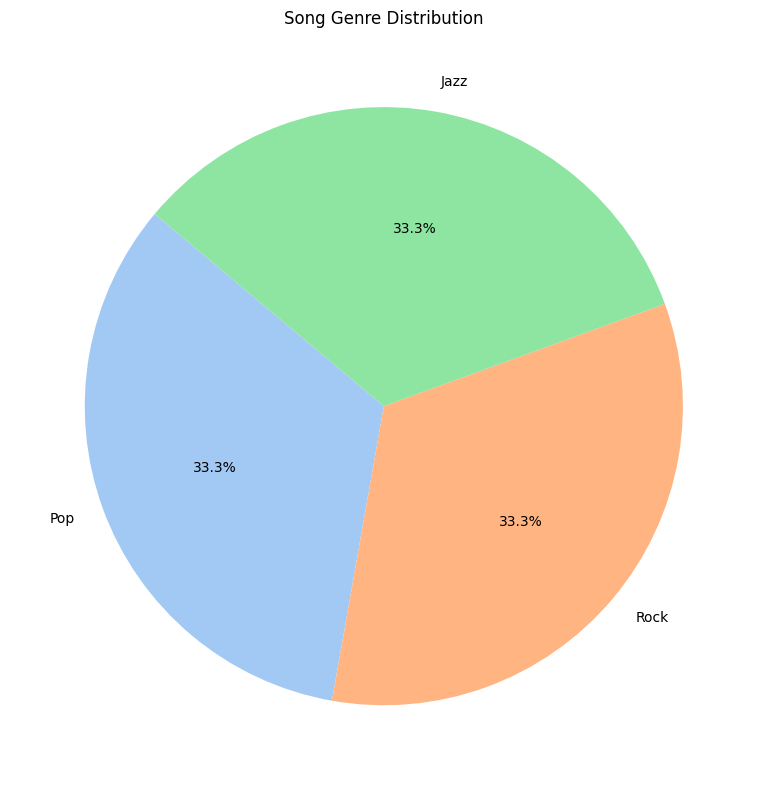

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample song metadata
song_data = pd.DataFrame({
    'song_id': ['S1', 'S2', 'S3', 'S4', 'S5', 'S6'],
    'title': ['Song A', 'Song B', 'Song C', 'Song D', 'Song E', 'Song F'],
    'genre': ['Pop', 'Rock', 'Pop', 'Jazz', 'Rock', 'Jazz']
})

# Sample user interaction data
interaction_data = pd.DataFrame({
    'user_id': ['U1', 'U2', 'U3', 'U1', 'U2', 'U3', 'U1', 'U2', 'U3'],
    'song_id': ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S1', 'S2', 'S3'],
    'play_count': [10, 15, 5, 7, 8, 4, 20, 25, 10]
})

# Visualization function
def visualize_data(df):
    # Top songs by plays
    plt.figure(figsize=(10, 6))
    top_songs = df.sort_values('play_count', ascending=False).head(5)
    sns.barplot(x='play_count', y='song_id', data=top_songs, palette='viridis')
    plt.title('Top Songs by Play Count')
    plt.xlabel('Play Count')
    plt.ylabel('Song ID')
    plt.tight_layout()
    plt.show()

    # Genre distribution
    plt.figure(figsize=(8, 8))
    genre_counts = df['genre'].value_counts()
    genre_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Song Genre Distribution')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

# Aggregate play counts
play_counts = interaction_data.groupby('song_id')['play_count'].sum().reset_index()

# Merge with song metadata
sample_data = pd.merge(song_data, play_counts, on='song_id')

# Visualize the data
visualize_data(sample_data)
